<a href="https://colab.research.google.com/github/mshilpaa/Deep-Neural-Network/blob/master/Assignment%204/assignment_4B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

Using TensorFlow backend.


In [3]:
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions - (32, 32, 3)
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


170500096/170498071 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-1
    elif epoch > 30:
        lr *= 1e-2
    elif epoch > 20:
        lr *= 1e-1
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """

RESNET56v2
For the input: conv2d(16,3x3)->BN-> RELU-1

Stage 1:
  res_block = 1
      y: [RELU-1  -> conv2d(16,1x1) ] -> [ BN-> relu-> conv2d(16,3x3) ] -> [BN-> relu-> CONV2D(64,1x1)-1]
        x: RELU-1 -> CONV2D(64,1x1)-2
      x = x+y ( CONV2D(64,1x1)-1  (+)  CONV2D(64,1x1)-2  )

    res_block = 2 to 6
        y: [BN-> relu-> conv2d(16,1x1) ] -> [ BN-> relu-> conv2d(16,3x3) ] -> [BN-> relu-> CONV2D(64,1x1)-1]
            x = x+y
Stage 2 to 3:
  res_block = 1
     y: [RELU-1  -> conv2d(64,1x1, s=2 ) ] -> [ BN-> relu-> conv2d(64,3x3) ] -> [BN-> relu-> CONV2D(128,1x1)-1]
     x: RELU-1 -> CONV2D(64,1x1, s=2 )-2
     x = x+y ( CONV2D(64,1x1)-1  (+)  CONV2D(64,1x1,s=2)-2  )

  res_block = 2 to 6
     y: [BN-> relu-> conv2d(64,1x1) ] -> [ BN-> relu-> conv2d(64,3x3) ] -> [BN-> relu-> CONV2D(128,1x1)-1]
     x = x+y 
      

    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,num_filters=num_filters_in,conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,num_filters=num_filters_in,kernel_size=1,strides=strides,activation=activation,batch_normalization=batch_normalization,conv_first=False)
            y = resnet_layer(inputs=y,num_filters=num_filters_in,conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [7]:
n = 6
depth = n * 9 + 2  
model = resnet_v2(input_shape=input_shape, depth=depth)
# Model name
model_type = 'ResNet56v2'

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

Learning rate:  0.001


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________

In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'resnet_cifar10_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


In [0]:
def get_random_eraser(p=0.5, s_l=0.01, s_h=0.2, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

    

In [13]:
# Run training, with data augmentation.
pixel_level = False
batch_size = 32
epochs = 50

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0,
        # set function that will be applied on each input
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=pixel_level) 
        )

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=50, verbose=1, workers=4,
                        callbacks=callbacks)


Using real-time data augmentation.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
Learning rate:  0.001
1563/1563 [==============================] - 135s 87ms/step - loss: 2.1239 - acc: 0.4682 - val_loss: 2.1066 - val_acc: 0.4627

Epoch 00001: val_acc improved from -inf to 0.46270, saving model to /content/saved_models/resnet_cifar10_model.h5
Epoch 2/50
Learning rate:  0.001
1563/1563 [==============================] - 118s 75ms/step - loss: 1.4967 - acc: 0.6032 - val_loss: 1.6020 - val_acc: 0.5705

Epoch 00002: val_acc improved from 0.46270 to 0.57050, saving model to /content/saved_models/resnet_cifar10_model.h5
Epoch 3/50
Learning rate:  0.001
1563/1563 [==============================] - 119s 76ms/step - loss: 1.2960 - acc: 0.6596 - val_loss: 2.5897 - val_acc: 0.4731

Epoch 00003: val_acc did not improve from 0.57050
Epoch 4/50
Learning rate:  0.001
1563/1563 [==============================] - 118s 76ms/step - loss: 1.1727 

In [0]:
from keras.preprocessing import image
import numpy as np
import cv2
from skimage import io
from keras import backend as K
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [0]:
(xtrain, ytrain), (xtest, ytest) = cifar10.load_data()


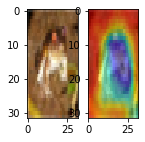

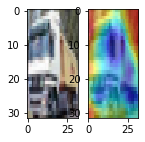

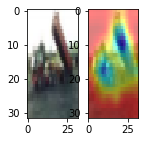

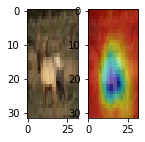

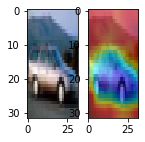

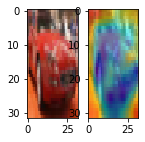

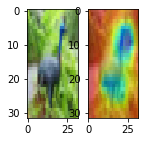

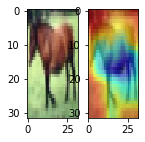

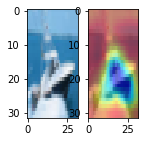

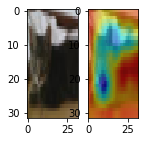

In [59]:
for i in range(10):
  input_image = xtrain[i]
  input_image1 = xtrain[i]
  input_image = input_image.astype('float32') / 255
  input_image = np.expand_dims(input_image, axis=0)
  preds = model.predict(input_image)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("activation_55")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([input_image])

  for i in range(64):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis = -1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (input_image1.shape[1], input_image1.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(input_image1, 0.5, heatmap, 0.5, 0)

  fig, ax = plt.subplots(figsize=(2,2),nrows=1, ncols=2)
  ax[0].imshow(input_image1,aspect='auto')
  ax[1].imshow(superimposed_img,aspect='auto')
  plt.show()


  